# **Introducción**

Telecom X es una empresa de telecomunicaciones y has sido contratado como Cientifico de Datos para trabajar en un proyecto específico de Churn de clientes. La empresa está enfrentando un alto índice de evasión de clientes  y aún no han identificado el problema de esta evasión.  Utilizar las herramientas de Machine Learning para obtener las mejores predicciones  y determinar de dónde proviene esta evasión de clientes.

## **1. Importación de bibliotecas**
Antes de comenzar, importamos las bibliotecas esenciales para el procesamiento de datos, visualización y aprendizaje automático.

In [70]:
## ✅ Importaciones Necesarias
import pickle
import joblib
import os
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

warnings.filterwarnings('ignore')

## **2. Carga de los datos**
Cargamos el archivo previamente limpiado para aplicar los modelos de machine Learning.

In [2]:
# Leer el archivo
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datos_tratados.csv")

In [3]:
df.columns = [col[0].upper() + col[1:] for col in df.columns]
df.columns = df.columns.str.replace('.', '_', regex=False)

In [4]:
df.head()

,Churn,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges_Monthly,Charges_Total
0,0,Female,No,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,0,Male,No,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,1,Male,No,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,1,Male,Yes,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,1,Female,Yes,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40


## **3. Transformar variables**
Hot encoding de las variables categóricas.

⚠️ El problema original

Variables como OnlineSecurity, StreamingTV, etc., tenían tres categorías:

* "Yes" → cliente usa el servicio
* "No" → cliente tiene internet, pero no contrató el servicio
* "No internet service" → cliente ni siquiera tiene internet, por lo tanto no puede usar el servicio

Esto generaba multicolinealidad perfecta al transformar estas categorías en dummies, lo que:

* Creaba correlación 1.0 entre variables
* Generaba VIF infinito
* Comprometía la estabilidad y el rendimiento de los modelos

_________________________________________________________________

✅ La solución: agrupar "No internet service" como "No"

* Agrupamos "No internet service" como "No" para simplificar la variable:

Ahora: "Yes" = usa el servicio "No" = no usa el servicio (por cualquier motivo)

* Esto reduce la dimensionalidad y evita multicolinealidad.

* La información de que el cliente no tiene internet sigue estando en la variable InternetService.

______________________________________________________________________
🧠 ¿Y el impacto?

* Perdemos un matiz (por qué el cliente no usa el servicio), pero:

    + Esto rara vez afecta el rendimiento del modelo
    + Ganamos más robustez, menos ruido y menos redundancia

In [5]:
# Separar variables categóricas y numéricas para una manipulación más limpia
numeric_features = df.select_dtypes(include=np.number).columns
categorical_features = df.select_dtypes(include='object').columns

In [6]:
## Revision de columnas tipo object
for col in categorical_features:
    if col in df.columns:
        display(df[col].value_counts(dropna=False))
        display("-" * 30)

,count
Gender,
Male,3549
Female,3483


'------------------------------'

,count
SeniorCitizen,
No,5890
Yes,1142


'------------------------------'

,count
Partner,
No,3639
Yes,3393


'------------------------------'

,count
Dependents,
No,4933
Yes,2099


'------------------------------'

,count
PhoneService,
Yes,6352
No,680


'------------------------------'

,count
MultipleLines,
No,3385
Yes,2967
No phone service,680


'------------------------------'

,count
InternetService,
Fiber optic,3096
DSL,2416
No,1520


'------------------------------'

,count
OnlineSecurity,
No,3497
Yes,2015
No internet service,1520


'------------------------------'

,count
OnlineBackup,
No,3087
Yes,2425
No internet service,1520


'------------------------------'

,count
DeviceProtection,
No,3094
Yes,2418
No internet service,1520


'------------------------------'

,count
TechSupport,
No,3472
Yes,2040
No internet service,1520


'------------------------------'

,count
StreamingTV,
No,2809
Yes,2703
No internet service,1520


'------------------------------'

,count
StreamingMovies,
No,2781
Yes,2731
No internet service,1520


'------------------------------'

,count
Contract,
Month-to-month,3875
Two year,1685
One year,1472


'------------------------------'

,count
PaperlessBilling,
Yes,4168
No,2864


'------------------------------'

,count
PaymentMethod,
Electronic check,2365
Mailed check,1604
Bank transfer (automatic),1542
Credit card (automatic),1521


'------------------------------'

In [7]:
## se estandariza el valor "No internet service" a "No" en varias columnas relacionadas con servicios de internet
cols_to_fix = [
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]

# Create df_clean by copying df
df_clean = df.copy()

for col in cols_to_fix:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].replace('No internet service', 'No')

In [8]:
# Aplicar One-Hot Encoding a las variables categóricas
df_processed = pd.get_dummies(df_clean, columns=categorical_features, drop_first=True, dtype=int)

In [9]:
df_processed.head()

,Churn,Tenure,Charges_Monthly,Charges_Total,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,9,65.6,593.30,0,0,1,1,1,0,0,0,0,0,1,0,1,1,0,1,0,1,0,0,1
1,0,9,59.9,542.40,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,1,4,73.9,280.85,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0
3,1,13,98.0,1237.85,1,1,1,0,1,0,0,1,0,0,1,1,0,1,1,0,0,1,0,1,0
4,1,3,83.9,267.40,0,1,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1


In [10]:
# Proporción de Churn
churn_ratio = df_processed['Churn'].value_counts(normalize=True) * 100
print("\nProporción de Clientes con Churn:")
print(f"No: {churn_ratio[0]:.2f}%")
print(f"Sí: {churn_ratio[1]:.2f}%")


Proporción de Clientes con Churn:
No: 73.42%
Sí: 26.58%


## **4. Analisis de Correlación**
Aplicamos un corte ~0.15 a los valores de la correlación con 'Churn' al fin de obtener solo las variables de mayor correlación para tener una perspectiva de analisis mas objetiva, al obtener los resultados de los modelos ML que se aplicaran.

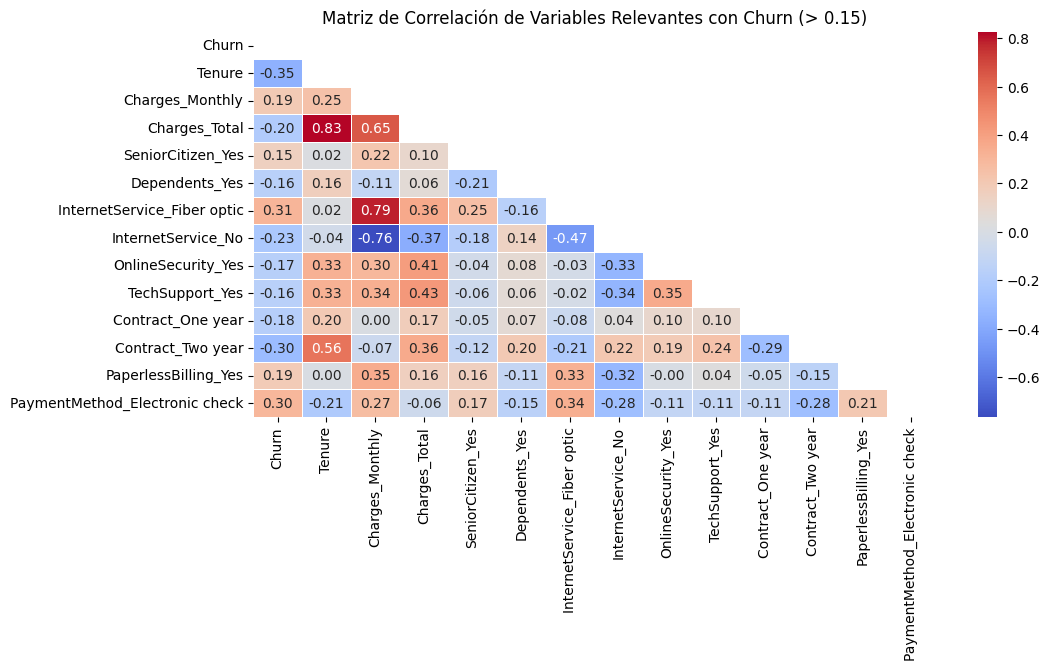

In [11]:
# Definir la variable objetivo
target_var = 'Churn'

# Definir el umbral mínimo de correlación absoluta para la selección
limiar = 0.15

# Calcular la matriz de correlación sobre el DataFrame original codificado (antes del balanceo)
correlation_matrix_original = df_processed.corr()

# Filtrar variables que tengan correlación absoluta >= limiar con la variable objetivo
# Esto crea una lista con las variables relevantes
variables_relevantes = correlation_matrix_original.index[abs(correlation_matrix_original[target_var]) >= limiar].tolist()

# Asegurar que la variable objetivo esté en la lista
if target_var not in variables_relevantes:
    variables_relevantes.append(target_var)

# Crear una matriz de correlación solamente con las variables seleccionadas
corr_filtrada = correlation_matrix_original.loc[variables_relevantes, variables_relevantes]

# Generar una máscara para esconder el triángulo superior de la matriz
mascara = np.triu(np.ones_like(corr_filtrada, dtype=bool))

# Plotear el heatmap con la máscara aplicada para mejor visualización
plt.figure(figsize=(11,5))
sns.heatmap(corr_filtrada, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, mask=mascara)
plt.title('Matriz de Correlación de Variables Relevantes con Churn (> 0.15)')
plt.show()

### Interpretación de Variables Clave Relacionadas con Churn

Basado en el análisis de correlación, los factores más influyentes en la cancelación de clientes son:

* Mayor Probabilidad de Cancelación:

  + Clientes con servicio de internet de fibra óptica.
  + Clientes que usan cheque electrónico como método de pago.

* Menor Probabilidad de Cancelación (Mayor Retención):

  + Clientes con mayor antigüedad (tenure).
  + Clientes con contratos de dos años (y en menor medida, de un año).
  + Clientes que no tienen servicio de internet (solo teléfono).
  + Clientes con servicios adicionales como seguridad en línea y soporte técnico.

En general, la antigüedad y el tipo de contrato son los predictores más fuertes de la retención, mientras que el servicio de fibra óptica y el método de pago con cheque electrónico están más asociados con la cancelación. Estos hallazgos son clave para enfocar los esfuerzos de retención.

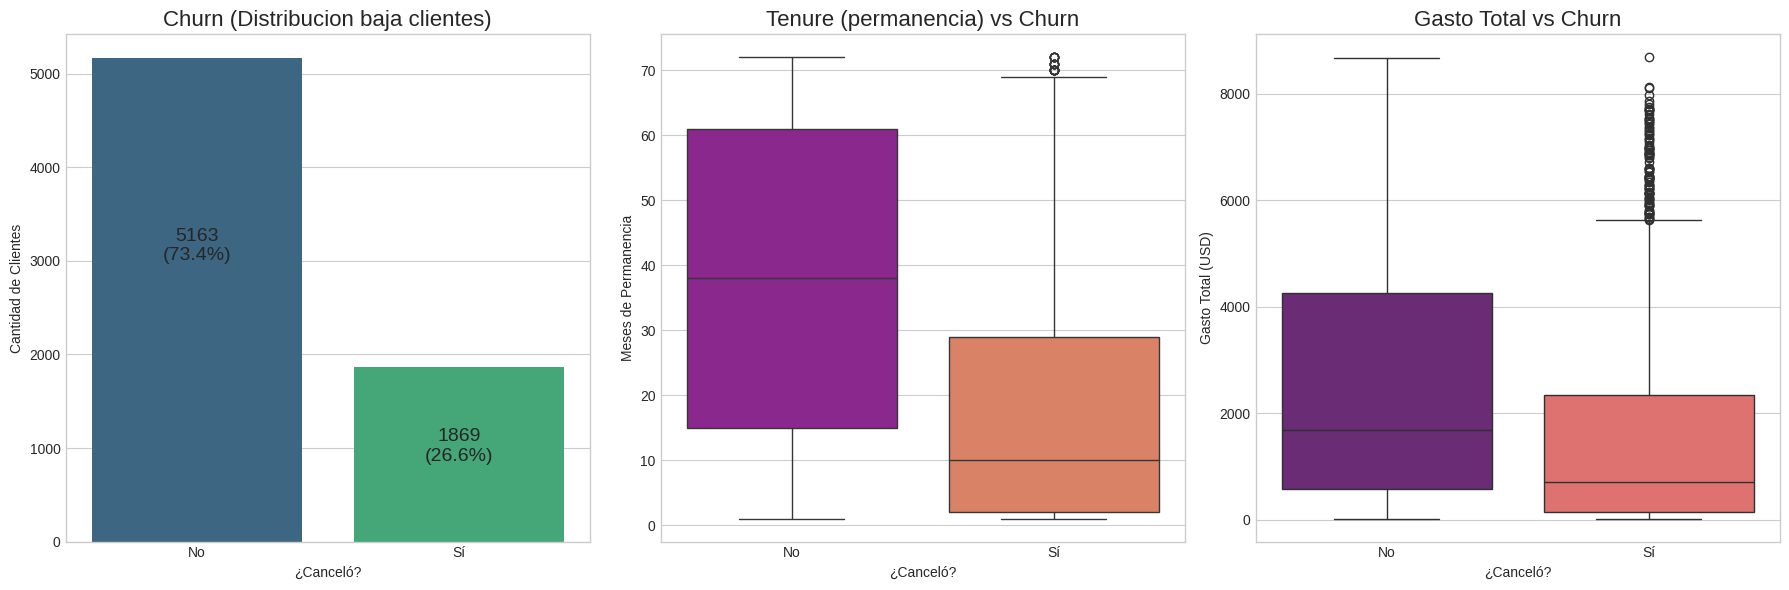

In [12]:
# Gráfico de distribución de Churn
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.countplot(x='Churn', data=df_processed, ax=axes[0], palette='viridis')
axes[0].set_title('Churn (Distribucion baja clientes)', fontsize=16)
axes[0].set_xticklabels(['No', 'Sí'])
axes[0].set_xlabel('¿Canceló?')
axes[0].set_ylabel('Cantidad de Clientes')

# Añadir valores y porcentajes en las barras
total = len(df_processed)
for p in axes[0].patches:
    height = p.get_height()
    axes[0].text(p.get_x() + p.get_width()/2., height * 0.65,
            '{:d}\n({:.1f}%)'.format(int(height), 100*height/total),
            ha="center", va="top", fontsize=14) # Añade alineación vertical


# Boxplot de 'tenure' vs 'churn'
sns.boxplot(x='Churn', y='Tenure', data=df_processed, ax=axes[1], palette='plasma')
axes[1].set_title('Tenure (permanencia) vs Churn', fontsize=16)
axes[1].set_xticklabels(['No', 'Sí'])
axes[1].set_xlabel('¿Canceló?')
axes[1].set_ylabel('Meses de Permanencia')

# Boxplot de 'total_charges' vs 'churn'
sns.boxplot(x='Churn', y='Charges_Total', data=df_processed, ax=axes[2], palette='magma')
axes[2].set_title('Gasto Total vs Churn', fontsize=16)
axes[2].set_xticklabels(['No', 'Sí'])
axes[2].set_xlabel('¿Canceló?')
axes[2].set_ylabel('Gasto Total (USD)')

plt.tight_layout()
plt.show()

In [13]:
# Gráficos interactivos con Plotly (reutilizando el DataFrame original)
df_vis = df[df['Churn'].isin([1, 0])].copy() # Asegurarse de tener un DataFrame limpio para plotly

print("\nGenerando gráficos interactivos con Plotly...")

fig_scatter = px.scatter(
              df_vis,
              x='Tenure',
              y='Charges_Total',
              color='Churn',
              title='Tenencia vs Gasto Total por Estado de Cancelación',
              labels={'Tenure': 'Meses como Cliente', 'Charges_Total': 'Gasto Total (USD)', 'Churn': '¿Canceló?'},
              hover_data=['Contract']
              )
fig_scatter.show()


Generando gráficos interactivos con Plotly...


## **5. Preparación para el Modelado con Técnicas de Machine Learning**
Utilizamos diferentes tecnicas que nos permiten realizar predicciones a un nivel avanzado, es necesario debido al desbalance de los datos.

In [14]:
# Separar características (X) y variable objetivo (y)
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

### 🔍 **5.1. Regresion logistica**

In [15]:
#Configuramos los parametros a utilizar:
pipe_lr = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(max_iter=1000))
])

param_grid_lr = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__penalty': ['l2'],
    'model__class_weight': [None, 'balanced']
}

gs_lr = GridSearchCV(
    pipe_lr,
    param_grid_lr,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

gs_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('model',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'model__C': [0.01, 0.1, 1, 10],
                         'model__class_weight': [None, 'balanced'],
                         'model__penalty': ['l2']},
             scoring='roc_auc')

In [16]:
best_model = gs_lr.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1292
           1       0.50      0.80      0.62       466

    accuracy                           0.74      1758
   macro avg       0.71      0.76      0.71      1758
weighted avg       0.80      0.74      0.75      1758

ROC AUC: 0.836485503394943


Matriz de Confusión:


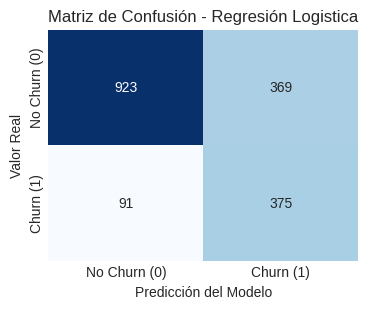

In [17]:
print("Matriz de Confusión:")
nombre_modelo = 'Regresión Logistica'
plt.figure(figsize=(4, 3))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Churn (0)', 'Churn (1)'],
            yticklabels=['No Churn (0)', 'Churn (1)'])
plt.title(f'Matriz de Confusión - {nombre_modelo}')
plt.xlabel('Predicción del Modelo')
plt.ylabel('Valor Real')
plt.show()

In [18]:
# Calcular la matriz de confusión
# Matriz de Confusión en formato de tabla
cm_df = pd.DataFrame(cm, index=['No Churn (0)', 'Churn (1)'], columns=['No Churn (0)', 'Churn (1)'])
display("-------------------------------------------Matriz de Confusión:--------------------------------------------")
display(cm_df)

'-------------------------------------------Matriz de Confusión:--------------------------------------------'

,No Churn (0),Churn (1)
No Churn (0),923,369
Churn (1),91,375


### 🌲 **5.2. Random Forest**

In [19]:
#Configuramos los parametros a analizar
pipe_rf = Pipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 15, 20],
    'model__min_samples_split': [2, 5],
    'model__class_weight': [None, 'balanced']
}

gs_rf = GridSearchCV(
    pipe_rf,
    param_grid_rf,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

gs_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('model',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__class_weight': [None, 'balanced'],
                         'model__max_depth': [None, 10, 15, 20],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [100, 200, 300]},
             scoring='roc_auc')

In [20]:
best_model = gs_rf.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1292
           1       0.54      0.69      0.61       466

    accuracy                           0.76      1758
   macro avg       0.71      0.74      0.72      1758
weighted avg       0.79      0.76      0.77      1758

ROC AUC: 0.8255873051728033


## **5.3. Arbol de decisión**

In [21]:
#Configuamos los parametros para utilizar las tecnicas de Arboles de decisión.
pipe_dt = Pipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('model', DecisionTreeClassifier(random_state=42))
])

param_grid_dt = {
    'model__max_depth': [None, 5, 10, 15, 20],
    #'model__min_samples_leaf':[1,2,3],
    'model__min_samples_split': [2, 5, 10],
    'model__class_weight': [None, 'balanced']
}
skf = KFold(n_splits=5, shuffle=True,random_state=5)
gs_dt = GridSearchCV(
    pipe_dt,
    param_grid_dt,
    scoring='roc_auc',
    cv=skf,
    n_jobs=-1
)

gs_dt.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=5, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('model',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__class_weight': [None, 'balanced'],
                         'model__max_depth': [None, 5, 10, 15, 20],
                         'model__min_samples_split': [2, 5, 10]},
             scoring='roc_auc')

In [22]:
best_model = gs_dt.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.88      0.75      0.81      1292
           1       0.50      0.71      0.59       466

    accuracy                           0.74      1758
   macro avg       0.69      0.73      0.70      1758
weighted avg       0.78      0.74      0.75      1758

ROC AUC: 0.7932415059992824


## **5.4. XGBoost con SMOTE**
Nota: XGBoost no necesita escalado, así que no usamos StandardScaler.

In [40]:
#XgBoost
pipe_xgb = Pipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('model', XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    ))
])
#Este grid es equilibrado entre calidad y tiempo:
param_grid_xgb_s = {
    'model__n_estimators': [200, 300, 400],
    'model__max_depth': [3, 5, 7, 10],
    'model__learning_rate': [0.01, 0.1],
    'model__subsample': [0.8, 1],
    'model__colsample_bytree': [0.8, 1]
}
#Usamos roc_auc como métrica principal (ideal para churn).
gs_xgb_s = GridSearchCV(
    pipe_xgb,
    param_grid_xgb_s,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

gs_xgb_s.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',
                                                      feature_types=None,
                                                      feature_weights=None,
                                                      gamma=None,
                                                      gr...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.8, 1],
                         'model__learning_rate': [0.01, 0.1],
                         'model__max_depth': [3, 5, 7, 10],
                         'model__n_estimators': [200, 300, 400],
                         'model__subsample': [0.8, 1]},
             scoring='roc_auc', verbose=1)

In [41]:
#✅ Evaluación en TEST (datos reales)
best_xgb = gs_xgb_s.best_estimator_

y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1292
           1       0.53      0.77      0.63       466

    accuracy                           0.76      1758
   macro avg       0.72      0.76      0.73      1758
weighted avg       0.80      0.76      0.77      1758

ROC AUC: 0.828330332584807


## **5.4. XGBoost con WEIGHT**

In [34]:
neg, pos = y_train.value_counts()[0], y_train.value_counts()[1]
scale_pos_weight = neg / pos

print("scale_pos_weight:", scale_pos_weight)

pipe_xgb = Pipeline(steps=[
    ('model', XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight
    ))
])
#Parametros mejor obtimizados
param_grid_xgb_w = {
    'model__n_estimators': [150, 300, 400, 500],
    'model__max_depth': [3, 5, 7, 10],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__subsample': [0.8, 1],
    'model__colsample_bytree': [0.8, 1]
}

gs_xgb_w = GridSearchCV(
    pipe_xgb,
    param_grid_xgb_w,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

gs_xgb_w.fit(X_train, y_train)

scale_pos_weight: 2.759087669280114
Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',
                                                      feature_types=None,
                                                      feature_weights=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=No...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.8, 1],
                         'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__max_depth': [3, 5, 7, 10],
                         'model__n_estimators': [150, 300, 400, 500],
                         'model__subsample': [0.8, 1]},
             scoring='roc_auc', verbose=1)

In [45]:
print("Mejores parámetros XGBoost con w:")
print(gs_xgb_w.best_params_)

Mejores parámetros XGBoost con w:
{'model__colsample_bytree': 1, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 500, 'model__subsample': 0.8}


In [35]:
best_xgb_w = gs_xgb_w.best_estimator_

y_pred = best_xgb_w.predict(X_test)
y_proba = best_xgb_w.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1292
           1       0.50      0.82      0.62       466

    accuracy                           0.74      1758
   macro avg       0.71      0.76      0.71      1758
weighted avg       0.81      0.74      0.75      1758

ROC AUC: 0.8377876732350948


In [55]:
#Procedemos a guardar nuestro modelo con pickle que necesita open.

try:
  ruta = "/content/drive/MyDrive/Modelo_Churn/"
  os.makedirs(ruta, exist_ok=True)
  modelo_final = gs_xgb_w.best_estimator_
  with open(f'{ruta}/champion_xgboost_w.pkl', 'wb') as file:
    pickle.dump(modelo_final, file)
  print('Modelo serializado con éxito')
  os.listdir(ruta)
except Exception as e:
  print('Se presentó un error al almacenar el modelo: ',str(e))

Modelo serializado con éxito


In [ ]:
#Como Cargar el modelo despues
modelo_cargado = pickle.load(f"{ruta}/champion_xgboost_w.pkl")

# Probar predicción
modelo_cargado.predict(X_test)

In [71]:
#También guardar con joblib que no neesita de open:
#simplemente >>> joblib.dump(modelo, "ruta/completa/archivo.pkl")
#Columnas usadas en entrenamiento
#Versión de librerías
#scale_pos_weight usado
ruta = "/content/drive/MyDrive/Modelo_Churn/"
os.makedirs(ruta, exist_ok=True)
ruta_modelo = os.path.join(ruta, "columnas_champion_xgboost_w.pkl")
# Guardar
joblib.dump(X_train.columns, ruta_modelo)

['/content/drive/MyDrive/Modelo_Churn/columnas_champion_xgboost_w.pkl']

In [ ]:
#Guardar con compatibilidad maxima con xgboost
#Esto guarda el modelo en formato nativo XGBoost (más portable)
'''
gs_xgb.best_estimator_.named_steps['model'].save_model(
    f"{ruta}/xgboost_model.json"
'''

## **6. Tabla Comparativa de los 3 Modelos Analizados**

In [42]:
models = {
    "Regresión Logística": gs_lr.best_estimator_,
    "Árbol de Decisión": gs_dt.best_estimator_,
    "Random Forest": gs_rf.best_estimator_,
    "XGBoost con S": gs_xgb_s.best_estimator_,
    "XGBoost con W": gs_xgb_w.best_estimator_
}

rows = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    rows.append({
        "Modelo": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba)
    })

metrics_df = pd.DataFrame(rows).set_index("Modelo")
metrics_df

,Accuracy,Precision,Recall,F1,ROC AUC
Modelo,,,,,
Regresión Logística,0.738339,0.504032,0.804721,0.619835,0.836486
Árbol de Decisión,0.738339,0.504559,0.712446,0.590747,0.793242
Random Forest,0.763367,0.541946,0.693133,0.608286,0.825587
XGBoost,0.758817,0.531065,0.770386,0.628722,0.828330
XGBoost con W,0.738339,0.503979,0.815451,0.622951,0.837788


## **7. Grafica de las 10 Variables mas decisivas para cada Modelo Entrenado**

### **7.1. Regresion Logistica**

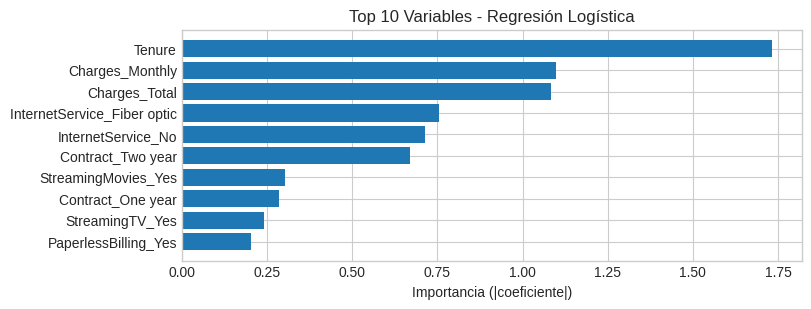

In [24]:
lr_model = gs_lr.best_estimator_.named_steps['model']
feature_names = X_train.columns

coef_df = pd.DataFrame({
    "feature": feature_names,
    "importance": np.abs(lr_model.coef_[0])
}).sort_values("importance", ascending=False).head(10)

plt.figure(figsize=(8, 3))
plt.barh(coef_df["feature"], coef_df["importance"])
plt.title("Top 10 Variables - Regresión Logística")
plt.gca().invert_yaxis()
plt.xlabel("Importancia (|coeficiente|)")
plt.show()

### **7.2. Random Forest**

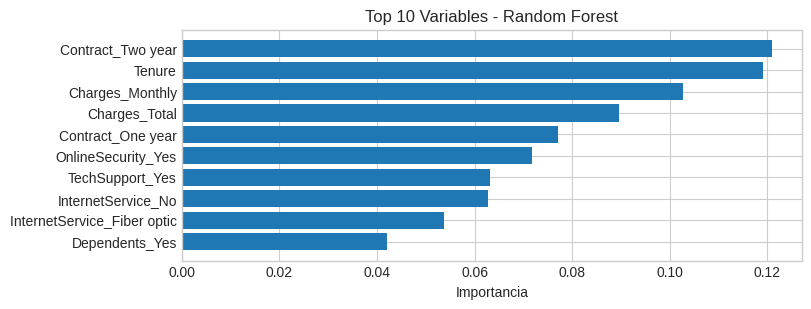

In [25]:
rf_model = gs_rf.best_estimator_.named_steps['model']

rf_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": rf_model.feature_importances_
}).sort_values("importance", ascending=False).head(10)

plt.figure(figsize=(8, 3))
plt.barh(rf_imp["feature"], rf_imp["importance"])
plt.title("Top 10 Variables - Random Forest")
plt.gca().invert_yaxis()
plt.xlabel("Importancia")
plt.show()

### **7.3. Árbol decisión**

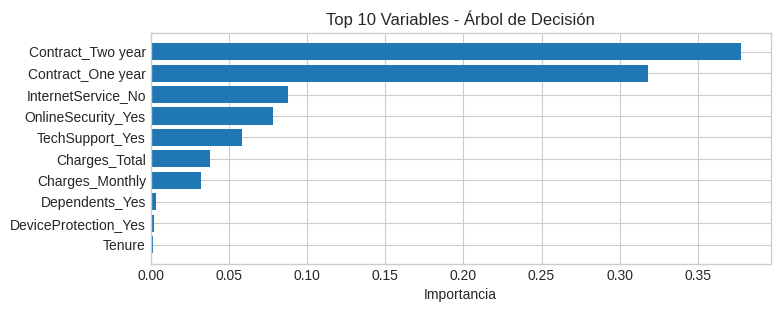

In [26]:
dt_model = gs_dt.best_estimator_.named_steps['model']

dt_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": dt_model.feature_importances_
}).sort_values("importance", ascending=False).head(10)

plt.figure(figsize=(8, 3))
plt.barh(dt_imp["feature"], dt_imp["importance"])
plt.title("Top 10 Variables - Árbol de Decisión")
plt.gca().invert_yaxis()
plt.xlabel("Importancia")
plt.show()

### **7.4. XGBoost**

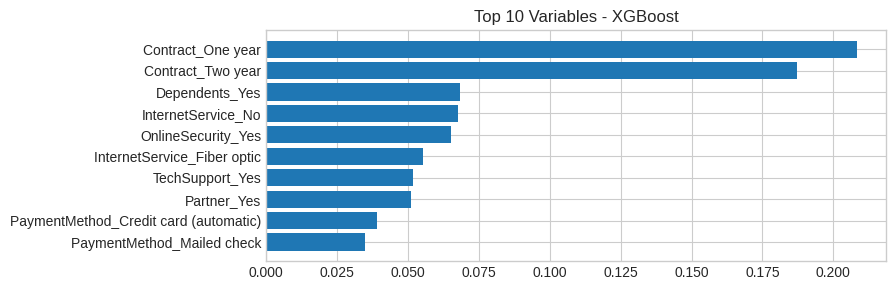

In [32]:
xgb_model = best_xgb.named_steps['model']

importance_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": xgb_model.feature_importances_
}).sort_values("importance", ascending=False).head(10)

plt.figure(figsize=(8,3))
plt.barh(importance_df["feature"], importance_df["importance"])
plt.title("Top 10 Variables - XGBoost")
plt.gca().invert_yaxis()
plt.show()

## ✅ **8. Conclusión**

Factores de Influencia en la Cancelación y Estrategias de Retención
Este informe resume los hallazgos clave del análisis de datos y el modelado predictivo realizado para identificar los factores que más influyen en la cancelación de clientes (Churn) y propone estrategias de retención basadas en estos resultados.

 1. Factores Clave que Influyen en la Cancelación:

  * El análisis de correlación y la importancia de variables obtenida de los modelos de Regresión Logística, Random Forest y XGBoost, convergen en gran medida en la identificación de los siguientes factores como los más influyentes en la probabilidad de que un cliente cancele su servicio:

* Antigüedad del Cliente (tenure): Consistentemente identificada como uno de los predictores más fuertes de retención. Los clientes con mayor antigüedad tienen una probabilidad significativamente menor de cancelar.

* Tipo de Contrato (Contract_Two year, Contract_One year): Los contratos a largo plazo, especialmente los de dos años, son un factor protector muy importante contra el churn. Los clientes con contratos mes a mes son mucho más propensos a cancelar.

* Tipo de Servicio de Internet (InternetService_Fiber optic, InternetService_No): El servicio de internet de fibra óptica está asociado con una mayor probabilidad de churn, mientras que no tener servicio de internet (solo teléfono) está asociado con una menor probabilidad de churn. Esto podría sugerir que los clientes de fibra óptica son más sensibles al precio o buscan constantemente mejores ofertas, mientras que los clientes solo de teléfono tienen necesidades más básicas y estables.

* Método de Pago (PaymentMethod_Electronic check): El uso de cheques electrónicos como método de pago se correlaciona con una mayor probabilidad de cancelación.

Otros factores que, aunque con menor impacto según el análisis de correlación, también mostraron cierta relevancia en el análisis exploratorio incluyen el gasto total (Charges.Total) y la ausencia de servicios adicionales como seguridad en línea y soporte técnico.

  2. Evaluación y Rendimiento de los Modelos:
Hemos evaluado tres modelos de clasificación: Regresión Logística, Random Forest y XGBoost, utilizando métricas clave como Accuracy, Precision, Recall, F1-score y AUC-ROC.

* Enfoque en el Recall (Clase 1 - Churn): Dado que el objetivo principal es identificar a los clientes propensos a cancelar para aplicar estrategias de retención (minimizar Falsos Negativos), el Recall para la clase Churn es una métrica crítica.

* Comparación de Modelos:
    + El modelo de Regresión Logística mostró el Recall más alto (aproximadamente 80%) para la clase Churn en el conjunto de prueba y el mejor AUC-ROC promedio en la validación cruzada. Esto lo posiciona como el mejor modelo para identificar a la mayoría de los clientes que van a cancelar. Sin embargo, su Precision para la clase Churn es la más baja, lo que implica una mayor tasa de Falsos Positivos (identifica a algunos clientes como propensos a cancelar cuando en realidad no lo harán).

  * Random Forest y XGBoost también mostraron un buen Recall (alrededor del 75-76%) y un rendimiento general sólido (AUC-ROC). XGBoost tuvo un AUC-ROC ligeramente superior a Random Forest en el conjunto de prueba y en la validación cruzada. Random Forest mostró la mayor estabilidad en la validación cruzada (menor desviación estándar del AUC-ROC).

  * Overfitting/Underfitting: La comparación de métricas entre los conjuntos de entrenamiento balanceado y de prueba no mostró signos claros de underfitting. Si bien los modelos de Random Forest y XGBoost tuvieron un rendimiento ligeramente mejor en el conjunto de entrenamiento balanceado en comparación con el conjunto de prueba, lo cual es esperado, las diferencias no fueron drásticas, lo que sugiere que el overfitting no es un problema severo con estos modelos.

3. Estrategias de Retención Basadas en los Resultados:
Basándonos en los factores que más influyen en el churn y el rendimiento de los modelos, se proponen las siguientes estrategias de retención:

    * Programas de Fidelización por Antigüedad: Implementar programas de recompensas o descuentos para clientes con mayor antigüedad para reconocer su lealtad y desincentivar la cancelación.

    * Incentivos para Contratos a Largo Plazo: Ofrecer descuentos, promociones exclusivas o beneficios adicionales a los clientes que renueven o cambien a contratos de uno o dos años.

    * Análisis Específico para Clientes de Fibra Óptica: Investigar las razones detrás del mayor churn en clientes con servicio de fibra óptica. ¿Se debe al precio, problemas de servicio, o la competencia ofrece mejores alternativas? Diseñar ofertas o programas de soporte técnico mejorados específicamente para este segmento.

    * Alternativas de Pago y Comunicación: Promover métodos de pago automático (transferencia bancaria, tarjeta de crédito) y educar a los clientes sobre sus beneficios. Ofrecer incentivos para cambiar del pago con cheque electrónico.

    * Identificación Proactiva de Clientes en Riesgo: Utilizar el modelo predictivo con el mejor Recall para la clase Churn (en este caso, Regresión Logística) para identificar proactivamente a los clientes con alta probabilidad de cancelar. Una vez identificados, se pueden aplicar intervenciones específicas (llamadas de retención, ofertas personalizadas, mejoras en el servicio).

    * Monitoreo de Clientes con Gasto Total Bajo: Prestar especial atención a los clientes con bajo gasto total, especialmente en los primeros meses, ya que esto podría ser un indicador temprano de insatisfacción o baja probabilidad de permanencia.

    * Promoción de Servicios Adicionales: Destacar los beneficios de servicios como seguridad en línea y soporte técnico, ya que se correlacionaron con una menor probabilidad de churn. Ofrecer paquetes atractivos.

4. Recomendaciones Adicionales:

    * Monitoreo Continuo del Modelo: Es fundamental monitorear el rendimiento del modelo predictivo en tiempo real y reentrenarlo periódicamente con datos actualizados para asegurar su precisión a lo largo del tiempo.

    * Análisis Cualitativo: Complementar el análisis cuantitativo con encuestas a clientes que cancelaron o entrevistas para obtener una comprensión más profunda de las razones detrás del churn.

    * Segmentación de Clientes: Utilizar los hallazgos sobre los factores de influencia para segmentar a los clientes en grupos de riesgo y adaptar las estrategias de retención a las características de cada segmento.

En conclusión, comprender los factores que impulsan la cancelación (principalmente antigüedad, tipo de contrato, servicio de internet y método de pago) y utilizar modelos predictivos para identificar a los clientes en riesgo son pasos cruciales para implementar estrategias de retención efectivas y reducir la tasa de churn. El modelo de Regresión Logística, con su alto Recall para la clase Churn, es una herramienta valiosa para la identificación temprana de clientes en riesgo.